# Large Vision & Language Decoder Models


In [6]:
# !pip install transformers==4.47.0
# !pip install -U bitsandbytes

import requests
from PIL import Image
import torch 
from transformers import (
  LlavaForConditionalGeneration,
  AutoTokenizer,
  AutoProcessor,
  # StopStringCriteria,
  BitsAndBytesConfig
)

def cuda_info():
    print()
    print("cuda.is_available: \t", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("cuda.device_count: \t", torch.cuda.device_count())
        print("cuda.current_device: \t", torch.cuda.current_device())
        print("cuda.device: \t\t", torch.cuda.device(torch.cuda.current_device()))
        print()
        print("cuda.get_device_name: \t", torch.cuda.get_device_name(torch.cuda.current_device()))
        print("total memory: \t\t", torch.cuda.get_device_properties(0).total_memory)
        print("reserved memory:\t", torch.cuda.memory_reserved(0))
        print("allocated memory:\t", torch.cuda.memory_allocated(0))


    device = "cuda:" + str(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu"
    print()
    print("device name: \t\t", device)
    return device

device = cuda_info()



cuda.is_available: 	 False

device name: 		 cpu


In [7]:
checkpoint = "Intel/llava-gemma-2b"

# Load model
model = LlavaForConditionalGeneration.from_pretrained(checkpoint).to(device)

# If your GPU has limited memory, you can use quantization_config to load the model in 8-bit:
#quantization_config = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=200.0) 
#model = LlavaForConditionalGeneration.from_pretrained(checkpoint, 
#                                                      quantization_config=quantization_config,
#                                                      do_sample=False)

processor = AutoProcessor.from_pretrained(checkpoint)

cuda_info()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tneto\anaconda3\envs\nlp-cv-ir\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tneto\AppData\Local\Temp\ipykernel_14568\1123483108.py", line 4, in <module>
    model = LlavaForConditionalGeneration.from_pretrained(checkpoint).to(device)
  File "c:\Users\tneto\anaconda3\envs\nlp-cv-ir\lib\site-packages\transformers\modeling_utils.py", line 3075, in from_pretrained
    tags = self.model_tags if self.model_tags is not None else []
  File "c:\Users\tneto\anaconda3\envs\nlp-cv-ir\lib\site-packages\transformers\configuration_utils.py", line 612, in from_pretrained
    proxies = kwargs.pop("proxies", None)
  File "c:\Users\tneto\anaconda3\envs\nlp-cv-ir\lib\site-packages\transformers\configuration_utils.py", line 764, in from_dict
    return config, kwargs
  File "c:\Users\tneto\anaconda3\envs\nlp-cv-ir\lib\site-packages\transformers\models\lla

# Load an example image

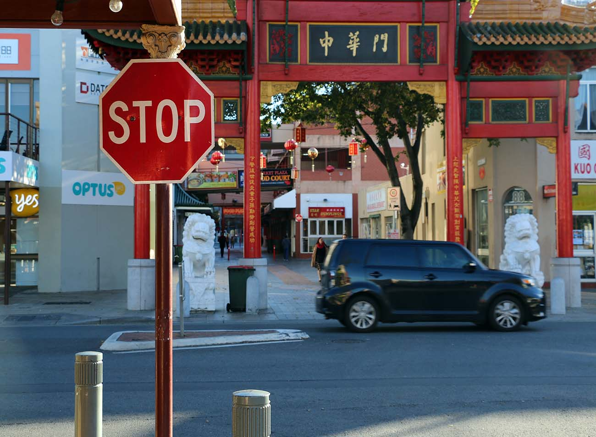

In [3]:
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')  
display(image.resize((596, 437)))


# Prompted image captioning

In [4]:
prompt = "<image>The car is"

inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
print(generated_text)


NameError: name 'processor' is not defined

# Chat Template

In [7]:
# Use gemma chat template
prompt = processor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': "<image>\nWhat's the content of the image?"}],
    tokenize=False,
    add_generation_prompt=True
)
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
generate_ids = model.generate(**inputs, max_length=50)
output = processor.batch_decode(generate_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False)[0].strip()
print(output)


<bos><bos><start_of_turn>user
<image>
What's the content of the image?<end_of_turn>
<start_of_turn>model
The image features a red stop sign on a city street, with a red and white sign on a pole nearby. There is a red and white


In [8]:
# Use gemma chat template
prompt = processor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': "<image>\nWhat's the content of the image?"}],
    tokenize=False,
    add_generation_prompt=True
)
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
generate_ids = model.generate(**inputs, stopping_criteria = [StopStringCriteria(tokenizer = processor.tokenizer, stop_strings=["<end_of_turn>"])], max_length=80)
output = processor.batch_decode(generate_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False)[0].strip()
print(output)


<bos><bos><start_of_turn>user
<image>
What's the content of the image?<end_of_turn>
<start_of_turn>model
The image features a red stop sign on a city street, with a red and white sign on a pole nearby. There is a red and white stop sign on the sidewalk, and a red and white stop sign on a pole. A car is driving down the street, and a person is crossing
